# MNIST with Pytorch

### Contents
0. Introduction
1. Imports and dataset
2. Problem of recognizing hand written digits with a neural net
3. Training the MLP
4. Testing the MLP
5. Convolutions to the rescue


## 0. Introduction 

Computer Vision is a sub-field of AI that focuses on automated processing of visual information. There are many different types of applications and methods in Computer Vision, some of which employ Deep Learning, others don't. In this workshop we will focus on methods that do employ Deep Learning. We will give a brief introduction to what Deep Learning is and will then walk you through hands-on examples of Deep Learning models for Computer Vision.

Deep learning is a data science method that is often applied to problems where a task needs to be solved that would require a lot of repetitive human effort but that is still too complex in order to solve it with straightforward code. Examples of these problems are object classification or detection in images (also including medical images in e.g., tumor detection), language processing (including translation, sentiment analysis, and question answering), but also tasks like stock trading, image generation or fraud detection.

The basis in all these problem settings is consituted of three basic parts. First, the problem needs to be defined as a specific task to solve, the so called objective function. Second, there needs to be a dataset on which this task needs to be solved. Third, a model is needed that will attempt to solve the task on the given dataset.

In this tutorial we will focus mostly on the dataset part and will also touch upon the importance of choosing the right model for the right task. We will generally ignore the wide varieties of objective functions that can be applied when using the same model or the same dataset, however we will still clearly define the task and objective function.

### PyTorch

We will be using the [PyTorch](https://pytorch.org/) library, which is "an optimized tensor library for deep learning using GPUs and CPUs". Tensors are a data format that allow us to use the graphics processing unit (GPU). The GPU is the video chip any computer needs in order to display non-textual content. Initially, strong GPUs have been developed by the gaming industry forming the basis for what has become near-realistic video games. However, in recent years, researchers in AI and other fields have been using GPUs in order to parallelize computations. This has been found to be specifically fruitful for training Deep Neural Networks as the computation of gradients, which are needed in order to "teach" the network using its "mistakes", can be done in parallel.

Even though this is a basic introduction, it outlines the requirements for training a deep learning model for a given problem. We know that we need a dataset on which we can solve a problem, a model that will do this for us and a GPU. Using this Google Colab notebook, we have direct access to a GPU server. We have also learned that in order to use the GPU, our data needs to be in the format of tensors. Let's now start with taking a look at our dataset.

------------------------------------------------------------------------------------------------------------------

Acknowledgements

Niklas Müller and Max van Spengler 

## 1. Imports and dataset

Here, we specify the kind of transformations that should be applied to each individual image in the dataset. This could be data augmentation, resizing of images and many other types of transformations. For this tutorial, as stated above, we limit this to transforming the images to the format of tensors. If you want to know more about potential transformations that could be applied, feel free to ask one of the instructors.

In [1]:
# Imports (Load pacakges that are needed)
import torch                              # <- PyTorch library for Tensors
from torch.utils.data import DataLoader
from torch import nn
import torchvision                        # Specialization of Torch for Computer vision
from torchvision import transforms

import os
import matplotlib.pyplot as plt           # Plotting library
import numpy as np                        # Numerical computations on CPU

from tqdm.notebook import tqdm            # Library to track progress of processes

In [2]:
#create a list to make all possible tasks sequential
transform_list = []
transform_list.append(transforms.ToTensor())
transform = transforms.Compose(transform_list)

In [3]:
transform_list

[ToTensor()]

We will be using the MNIST dataset, which is an image dataset containing images of handwritten digits. This is a historically important dataset as it perfectly illustrates the kind of problems that people wanted to outsource to AI systems. Imagine you would have to go through thousands of images of handwritten digits (think of post codes, marks in education, etc.) and document/digitize them into a database. As this is highly repetitive and on top cognitively not very challenging, people started to implement systems that would do this for them. The MNIST dataset is publicly available using the torchvision package, which is the Computer Vision extension of PyTorch. We can download the dataset using the below command.

In [4]:
mnist = torchvision.datasets.MNIST(root='.', download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 252429911.26it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 93903638.62it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 71280213.11it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4998826.76it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Another feature of pytorch is the dataloader. Given any kind of dataset (i.e. a python class that implements a function returning an indexed item) the dataloader allows us to use multiple cores/CPUs in order to parallelize the loading of items (here, images) from the disk and also applies the above transformations (here, formatting as a tensor) such that we can directly use it on our GPU. The below command defines a dataloader using the above MNIST dataset that we downloaded and loaded into this notebook. We want to use 8 cores in order to load 8 images from the disk at the same time. We also tell it the batch size, which is the number of images that it loads from the dataset in one iteration. All of these images will then be processes AT THE SAME TIME by the model when using a GPU. We can see why this would speed up the whole process a lot as compared to only being able to process a single image at the same time if we were to do this on a CPU instead.

Source:
- https://pytorch.org/docs/stable/data.html

In [5]:
dataloader = DataLoader(dataset=mnist, batch_size=4096, num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
dataloader

We can then iterate over this dataloader (either by using the iter function together with the next function to get the next iteration, or using any loop).

As you can see, the dataloader does not only return an image but it also return a corresponding label to the image. This label tells us what digit is visible in the image. Using this pair of image and label we can directly define the task that we would want the model to solve: given the image as an input, output the digit that is visible in the image. Before we will go into how to teach a model to do that, let's have a look at the actual images.

In [10]:
img, label = next(iter(dataloader)) # Create an iterator of the dataloader and get the "next" iteration

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
img.shape

torch.Size([4096, 1, 28, 28])

Even though we only loaded one iteration of the dataloader, we got 4096 pairs of image and label. This is the batch of items that we defined above that will be processed in parallel. We can also see that the images have a size of 28x28 pixels and that they have 1 channel, meaning that the images do not have color but are grayscale only. Let's visualize some of the images. If you execute the below cell multiple times, new random images will be plotted from the above batch.

Do you disagree with any of the labels? Are some images ambiguous?

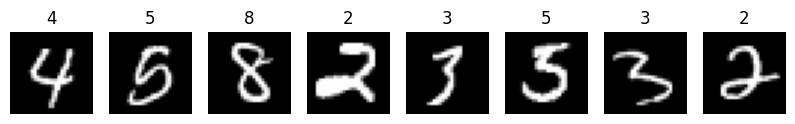

In [12]:
fig, ax = plt.subplots(1,8, figsize=(10, 5))

for ax_index, index in enumerate(np.random.randint(0, 4096, size=8)):
  ax[ax_index].imshow(transforms.ToPILImage()(img[index]), cmap='gray')
  ax[ax_index].set_title(label[index].numpy())
  ax[ax_index].axis('off')

plt.show()

## 2. Problem and Multi-Layered Perceptron
Now, that we have an idea of what the dataset looks like, and we have defined the problem that we would want to be solved, we can create a model that can help us solve this for us.

One of the simplest Neural Networks (that is in fact not a "Deep" network; more to this later) is the Multi-Layer Perceptron or MLP.

The MLP is characterized by 4 core concepts.

The first is **nodes**. A node is the smallest unit of the network and computes a single function on some input. Each of the green dots in the below image is one such unit or node. Nodes either get the original data as input or more importantly, can get the *output* of another node as *input*. A function, often non-linear, is then computed on this input and the resulting output is either past on to the next node or it constitutes the output of the entire model, e.g., the digit corresponding to the input image.

The second concept is a **layer**. In the image, we see that this particular MLP has three layers: input layer, hidden layer, and output layer. As maybe intuitively clear, the input layer gets the image as input. Each node in the input layer receives the value of exactly one pixel of the image. So in our case we would have 28*28=784 nodes in the input layer. The number of nodes in the hidden layer can be arbitrarily specified by the user but crucially determines (to some extent) whether the model can solve the task at hand or not.

The last layer usually corresponds to the number of output options. In our case, there are 10 digits, therefore the output layer would have 10 nodes. Each of these nodes represents one digit and outputs a value between 0 and 1 which will in turn be interpreted as the probability that that digit is visible in the input image. So contrary to a common belief, the model does not output a single number directly telling us the digit, but instead it outputs a probability for each digit with which it "thinks" that that digit is visible in the image.


![link text](https://media.geeksforgeeks.org/wp-content/uploads/nodeNeural.jpg)

<sub>https://media.geeksforgeeks.org/wp-content/uploads/nodeNeural.jpg<sub>

The third concept is **scalability**. We already heard that the particular MLP that we would use in our case would have 784 input nodes, some hidden nodes and 10 output nodes and therefore differs from the MLP instance that is shown in the image below. MLPs can come in any size. Interestingly, this is not only limited to the number of nodes per layer but also applies to the number of hidden layers. Every MLP also has one input layer and one output layer but everything inbetween is "arbitrily" defined. This is commonly referred to as the "Black Box" when talking about Neural Networks, as it becomes harder and harder (up to impossible) to disentagle with what kind of behaviour the MLP model is solving the given task.

Below is a MLP that illustrates multiple hidden layers and also shows that each layer can have a different number of nodes.

![](https://www.researchgate.net/publication/354817375/figure/fig2/AS:1071622807097344@1632506195651/Multi-layer-perceptron-MLP-NN-basic-Architecture.jpg)

<sub>https://www.researchgate.net/publication/354817375/figure/fig2/AS:1071622807097344@1632506195651/Multi-layer-perceptron-MLP-NN-basic-Architecture.jpg<sub>


The last and likely most important concept is **learnability**. So far, we have talked about the input and output, the nodes and layers, and that all of that can be scaled up or down. But there are also connections between all the nodes. These symbolize the weights that are assigned between pairs of nodes. Weights are essentially real-valued numbers that are multiplied with the input in order to transform the input of an individual node to the output of that node.

We can see that for all the hidden layers, and the output layer in the two images above, the nodes have an arrow, i.e. a weight, coming from EVERY single node in the previous layer. So every node gets input from all nodes in the previous layer. If we image that the input is an image, then this means that each node in the (first) hidden layer has access to information from all nodes in the input layer and therefore to information from the WHOLE image. All of that information is then weighted by the values of the connections between the nodes after which a non-linear function, called activation function, is being applied. So a given node is computing the weighted sum of all its inputs (which is a linear computation) followed by a non-linear computation.

![](https://www.researchgate.net/publication/354817375/figure/fig1/AS:1071622807117824@1632506195623/A-single-neuron-receiving-weighted-inputs.jpg)

<sub>https://www.researchgate.net/publication/354817375/figure/fig1/AS:1071622807117824@1632506195623/A-single-neuron-receiving-weighted-inputs.jpg<sub>


Often the Rectified Linear Unit (ReLU) or the Sigmoid function are used as activation functions.


![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*XxxiA0jJvPrHEJHD4z893g.png)


<sub>https://miro.medium.com/v2/resize:fit:720/format:webp/1*XxxiA0jJvPrHEJHD4z893g.png<sub>

### Model Implementation

This has been a long but needed explanation for how a typical MLP model looks like. We now have all the ingredients to build one using PyTorch.

Counterintuitively, a layer in PyTorch (or any other deep learning library) is rather defined as the set of weights instead of the set of nodes per layer. So a PyTorch layer will be defined in terms of the number of input nodes and the number of output nodes and the type of computation that is applied to the input. In our case we want that computation to be the weighted sum of inputs. This is called a Linear Layer. We want that to be follow by a ReLU operation as the activation function.

Our model needs 784 input nodes, one hidden layer with a high enough number of nodes and a output layer with 10 nodes.

In [13]:
class MLP(nn.Module):       # <- nn.Module builds the basis for any model
    def __init__(self, in_channels, out_channels, hidden_channels):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),  # Set of weights connecting the number of input nodes (defined by in_channels)
                                                      #       to the number of hidden nodes (defined by hidden_channels)
                                                      #       and the type of computation applied to them (weighted sum = Linear)
            nn.ReLU(),                                # Rectified Linear Unit - Activation function applied to every output (so the weighted sum of inputs) of the previous layer.
            nn.Linear(hidden_channels, out_channels)  # Same as above but now connecting the hidden layer to the output layer
        )


    # The forward function is called when the model receives an input X and defines how the model processes this input.
    # Here, the input is first flattened, going from 3-Dimensional to 1-Dimensional such that the number of pixels correspond to the number of input nodes.
    # Then, the input is fed through the network, meaning that all the weighted sums and activations are being applied and
    #     yielding an output telling us the probability for each of the possible digits on how likely that digit is visible in the image.
    def forward(self, x):
        # convert tensor (128, 1, 28, 28) --> (128, 1*28*28)
        x = x.view(x.size(0), -1)   # flatten
        x = self.layers(x)          # feed through network
        return x                    # return output

The above cell only defines the class that we can now create an instance of, specifying the exact number of nodes per layer. As said above, we need 784 input nodes and 10 output nodes. Additionally, we want the hidden layer to have 100 nodes. Feel free to play around with the number of hidden nodes, e.g. make it 10 or 1000 and see how the model's behaviour changes. Please do this after the end of the workshop in the interest of time.

In [14]:
model = MLP(in_channels=28*28, hidden_channels=100, out_channels=10)

In [18]:
model

MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)

Note that this model could already be used to execute the task. However, given that its parameters (i.e., the weights of each pair of nodes) are initialized randomly the model output would also be random.

## 3. Training the MLP

Now, we want to change/tune the weights such that the model output corresponds to the label for the given input image. To do this, we need of course the image itself and the corresponding label.

Next, we need a measure of how well the model is doing. This is referred to as the loss function. This will tell us how close the output of the model is to the desired output. Remember, the model does not just output the digit itself but a probability distribution over all possible digits. If we conceptualize that a single correct answer (namely that there is only one digit visible per image) corresponds to a probability distribution that is 0 everywhere except for the number/node that corresponds to the digit then we can imagine that we can compute how similar to output distribution of the model is to the desired distribution that assigns a probability of 1 to the actual visible digit.

The similarity between these two distribution is given by the CrossEntropyLoss. For a given pair of distributions or rather predicted digits and target/desired digits, it calculates a single number which is close to 0 if the predicted digit matches the target digit and can be infinetly large for a predicted digit probability that is far away from the desired one.

Given this loss function, we can then calculate the gradient for each of the parameters of the model, i.e. the weights, and change or update these weights such that the loss would decrease if the model were to use these weights instead.

This yields the follow training paradigm:

1. Start with a pair of **input** (image) and corresponding **label** (digit)
2. Give the input to the model which feeds it through its layers and nodes and **outputs** a probably distribution over the possible outcomes.
3. Calculate the distance (or **loss**) between the model **output** and the **label** in terms of the CrossEntropyLoss function.
4. Calucalte the **gradient** for each parameter/weight given the **loss**.
5. Update the model parameters/weights according to the **gradient**.
6. Repeat for a new pair of **input** and **label**.

In [15]:
def train(model, loader, n_epochs, criterion, optimizer, device):
  model.train(True)

  for epoch in tqdm(range(n_epochs)):

    for item in tqdm(loader, leave=False):
      inputs, labels = item[0], item[1]       # Pair of input and corresponding label

      inputs = inputs.to(device)              # Move to desired device (always recommended to use GPU as calculation times drastically decreases for CPU use)
      labels = labels.to(device)              # Move to desired device (always recommended to use GPU as calculation times drastically decreases for CPU use)

      optimizer.zero_grad()                   # Set all gradient to 0, this is a technical step that is needed in order to only consider the gradients of this "round" of input-output-pairs and not the previous ones

      outputs = model(inputs)                 # Feed the input (image) through the model and get the probability distribution over targets (digits)

      loss = criterion(outputs, labels)       # Calculate the loss (distance or error) between outputs and labels using CrossEntropyLoss
      loss.backward()                         # Calculate the gradient for each parameter for the current loss

      optimizer.step()                        # Update each model parameter (weight) according to the calculated loss

Let's now define the remaining parts using PyTorch and then we can finally train our first model.

We need a loss function for which we will use the CrossEntropyLoss. We need an algorithm that updates each model parameter in a smart way given the loss. For this we will choose the commonly used Adam optimizer. Other common optimizers are SGD (stochstic gradient decent), LBFGS or RMSProp. A list of available optimizers in PyTorch can be found [here](https://pytorch.org/docs/stable/optim.html#algorithms).

In [16]:
criterion = torch.nn.CrossEntropyLoss() # Define loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # define optimizer, note that we have to tell the optimizer what parameters should be update. Here, we want all parameters to be updated
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # We define the GPU as the device that should be used during training, if a GPU is available. Note that everything said so far would also work on a CPU but would take much much longer

model = model.to(device) # Move the model to the desired device (GPU)

In [20]:
device

device(type='cuda')

We have learned earlier that the model (using a GPU) can handle multiple pairs of input and output at the same time (this is called a batch). So we cut the whole dataset up into batches. We can now iterate over those batches such that the model sees each pair of input and label once. This is called an epoch. Unfortunately, showing each pair of input and label once will not enable the model to adjust its parameters such that it can perfectly classify all images correctly. Therefore, we need to run multiple epochs (i.e. show the whole dataset multiple times to the model) in order for the model to achieve a sufficient classification performance.

The below cell executes the train function that we define above for a given model, loss function (criterion), optimizer and dataloader. We can further specify the device and the number of times the whole dataset is shown to the model (n_epochs). The cell below should finish after around 70 seconds for 10 epochs and the default model that we defined above. If you make changes to any if these parts, expect these times to differ.

Go ahead and train the model by executing the following cell:

In [19]:
train(model=model, loader=dataloader, n_epochs=10, criterion=criterion, optimizer=optimizer, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

## 4. Testing the MLP

To evaluate model performance we define a simple classication accuracy as the ratio of times the model assigned the highest probability to the actual target digit over the number of item in the dataset. For a given dataloader and model, the function below compute the just defined accuracy.

In [21]:
def evaluate(loader, model, device):
    num_correct = 0
    num_samples = 0
    model.eval()


    with torch.no_grad():
        with tqdm(enumerate(loader), total=len(loader), desc='0/0') as t:
            for i, (item) in t:
                x, y = item[0], item[1]

                x = x.to(device=device)
                y = y.to(device=device)

                scores = model(x)
                _, predictions = scores.max(1)
                num_correct += (predictions == y).sum()
                num_samples += predictions.size(0)

                t.set_description(f'{num_correct}/{num_samples} correct ')

        accuracy = float(num_correct)/float(num_samples)
        print(f'Got {num_correct} \t/ {num_samples} correct -> accuracy {accuracy*100:.2f} %')

    return accuracy


Let's see how well our model is doing after it has been trained for 10 epochs:

In [22]:
accuracy = evaluate(model=model, loader=dataloader, device=device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


0/0:   0%|          | 0/15 [00:00<?, ?it/s]

Got 55389 	/ 60000 correct -> accuracy 92.31 %


We see that the model performs nearly perfectly after it has been trained for 10 epochs.

An important additional check that is commonly done in Machine Learning is to test the model on data that it has not seen during training. While this might seem unfair or task irrelevant, we need to remember that the initial solution that we were looking for is a model that can tell us for any image of a handwritten digits, what digit is visible. And for such a model to be able to work reliably and autonomously, we would want it to also be able to classify digits that have been written by e.g., a new, unknown person.

The technical term for this is cross-validation. The easiest way to perform cross-validation for any given dataset is to simply split it into two new dataset. One is called the training dataset and would consist of around 90% of the original data and will be used for training the model. The other is called the test dataset and consists of the remaining 10% of data. The test dataset is then used for so called inference, i.e. the model has to make its prediction but weights won't be change if the output is wrong.

Many datasets, including MNIST, have a pre-defined test dataset for the outlined purpose. The test dataset can be accessed and downloaded by setting the 'train' argument to false.

In [24]:
mnist_test = torchvision.datasets.MNIST(root='.', download=True, transform=transform, train=False)

We can now assess/test the trained model's accuracy on this test dataset. Remember, this is data that the model has not seen before and could therefore not adjust its parameters to be able to predict the output class (digit) for these images.

We define a new dataloader for this test set and use the above 'evaluate' function to get the model's test performance in terms of classification accuracy.

In [25]:
testloader = DataLoader(dataset=mnist_test, batch_size=4096, num_workers=8)

In [26]:
accuracy = evaluate(model=model, loader=testloader, device=device)

0/0:   0%|          | 0/3 [00:00<?, ?it/s]

Got 9245 	/ 10000 correct -> accuracy 92.45 %


Impressively, the model is still able to predict almost all images correctly. Note that the size of the MNIST test set is 10000 pairs of input and output.

## 5. Convolutions to the rescue

You may or may not know convolutions from other fields or mathematics. Generally speaking, a convolution expresses how the shape of one function is influenced by another. It can also be thought of as a kind of filtering using one function that corresponds to the filter and another function that corresponds to the signal that is to be filtered.

In computer vision a convolution is usually referred to as a feature or a kernel. This is, because the function that represents the filter/kernel/feature is a sort prototype for a characteristic in the data as e.g., a straight line or a circle in an image. When a convolution that represent a straight line is being applied to a part of an image where a straight line is visible, this will yield the strongest output (defined by the mathematical computation behind the convolution which we will not inspect any closer here). When the same convolution is then applied to some other part where e.g. a circle is visible, this will yield a very weak output. In that sense, the output of a convolution reveals where and to what extent a certain feature or characteristic is present in an image.

To illustrate this, we can think back to how this would help in identifying the digit in a grayscale handwritten image. The handwritten 1,4 or 7 all have a lot of straight or diagonal lines while 3,6,8 or 0 all almost have no straight lines but more half-circles or circles. If we would apply the respective convolutions/kernel/features/filter to the handwritten digit images, we could easily learn something about the content of the images by just inspecting the distribution of occurences of these features (lines and circles).

The kernel itself is defined as a two-dimensional matrix commonly with size of 3x3, 5x5 or 7x7 where each entry in the matrix is a learnable real number that can be adjusted. The below image illustrates how such a matrix can form kernels corresponding to different types of straight lines or edges.

![](https://media5.datahacker.rs/2018/10/multiplication_slicice.png)
<sub>https://media5.datahacker.rs/2018/10/multiplication_slicice.png<sub>

During training the weights of the kernels (i.e. the values in the matrix) will be adjusted such that the resulting activations allow the model to distinguish parts of the images from other parts of the image.

Another large advantage of using convolutions is that a single convolutional kernel, e.g., corresponding to a straight line, can be applied to every location in the image without needing more than one set of weights. In case of the MLP, remember that the input layer needed to have as many nodes as there were pixels in the image and nodes in the hidden layer received input from all previous nodes. Here, one convolutional kernel, of which there would still be many in a neural network model, can be applied to all locations of the image, no matter how many pixels there are without changing the number of weights.

In [37]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        ####################### THIS BLOCK DEFINES EACH INDIVIDUAL COMPONENT THAT WE WILL BELOW BRING INTO THE ORDER NEEDED

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)               # Convolutional Layer with 3 channels as inputs, 32 channels as outputs (so that means it has 32 kernels/filters) a kernel size of 3 and a padding of 1

        self.relu = nn.ReLU()                                                 # ReLU activation layer. Can be "reused" multiple times as there are no weights attached to this directly

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)    # Conv layer with 32 in and 64 out channels

        self.max_pool = nn.MaxPool2d(2, 2)                                    # Max Pooling layer

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(256*4*4, 1024)                                   # Fully connected layer, needs flattening of the output of the previous layer which we will perform below
        self.fc2 = nn.Linear(1024, 512)                                       # Gradually decrease the number of nodes, down to the number of output classes
        self.fc3 = nn.Linear(512, 10)
        #######################


        ####################### Define the order of individual components with which the model should process the input
        self.layers = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.max_pool,  # output: 64 x 16 x 16

            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.max_pool,  # output: 128 x 8 x 8

            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.max_pool,  # output: 256 x 4 x 4

            nn.Flatten(),   # output: 256*4*4
            self.fc1,
            self.relu,
            self.fc2,
            self.relu,
            self.fc3
        )
        #######################


    ####################### The forward function defines what happens when the model is called on an input x. In this case we just call the layers block, with the predefined order of individual components
    # Note that we don't need to define the self.layers variable, but we can also call each individual component on the input, which eventuall just requires a bit more writing. See a short example below
    def forward(self, x):
        return self.layers(x)

        ####################### actually equivalent to:
        # x = self.conv1(x)
        # x = self.relu(x)
        # x = self.conv2(x)
        # etc. ...
        # ...
        # x = self.fc3(x)
        # return x

Just like above, we create a new model, now a convolutional one, choose our loss function (criterion), the optimization algorithm, and the device to run the training on and train the model.

In [38]:
conv_model = ConvNet()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

conv_model = conv_model.to(device)

In [39]:
train(model=conv_model, loader=cifar_loader, criterion=criterion, n_epochs=20, optimizer=optimizer, device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [40]:
accuracy = evaluate(model=conv_model, loader=cifar_loader, device=device)

0/0:   0%|          | 0/13 [00:00<?, ?it/s]

Got 31447 	/ 50000 correct -> accuracy 62.89 %


In [41]:
accuracy = evaluate(model=conv_model, loader=cifar_test_loader, device=device)

0/0:   0%|          | 0/3 [00:00<?, ?it/s]

Got 6088 	/ 10000 correct -> accuracy 60.88 %


After evaluating the trained model on the test set, we see that using convolutions in a simple model increase test accuracy significantly. However, the model still does not perform perfectly. This is again due to the size of the model. A larger model (i.e., a model with more convolutional layer and more channels per layer) would perform even better. However, here we could probably also squeeze out some performance improvements by just training the model for a bit longer. Due to the lack of time we will not look further into this but rather reside to another class of models.

Before we move on to the state-of-the-art models, we want to have a closer look at what the above model actually learned. The cool thing about convolutions is that we can visualize the leared features/channels/kernels. Since every kernel is a two-dimensional matrix (as we have seen above), this matrix can be visualized. The below function takes a list of images and plots them in a grid of axes. No need to go through this code.

In [42]:
def plot_images(images, fig=None, max_images: int = None, figsize=(15, 10), titles:list=None, cmap=None, axis_off:bool=True, orientation='landscape', custom_func_per_image=None):
    if max_images is None:
        max_images = len(images)

    if fig is None:
        fig = plt.figure(figsize=figsize)

    # if max_images % 2 == 1:
    #     n_rows = int(np.floor(np.sqrt(max_images)))
    #     n_cols = int(np.floor(np.sqrt(max_images)))
    # else:
    if orientation == 'landscape':
        n_rows = int(np.floor(np.sqrt(max_images)))
        n_cols = int(np.ceil(max_images / n_rows))
    else:
        n_cols = int(np.floor(np.sqrt(max_images)))
        n_rows = int(np.ceil(max_images / n_cols))

    index = 0
    for _ in range(n_rows):
        for _ in range(n_cols):
            if index >= max_images:
                break
            ax = fig.add_subplot(n_rows, n_cols, index+1)
            ax.imshow(images[index], cmap=cmap)
            if axis_off:
                ax.axis('off')
            if titles is not None and len(titles) > index:
                ax.set_title(titles[index])

            if custom_func_per_image is not None:
                custom_func_per_image(ax, index)
            index += 1

    fig.tight_layout()

    return fig

Let's pick one of the convolutional layer of the above model and visualize the trained kernels.

In [47]:
kernels = conv_model.conv6.parameters() # <- we can change conv1 to any of the other convolutional layers of the model
param_iter = next(iter(kernels))

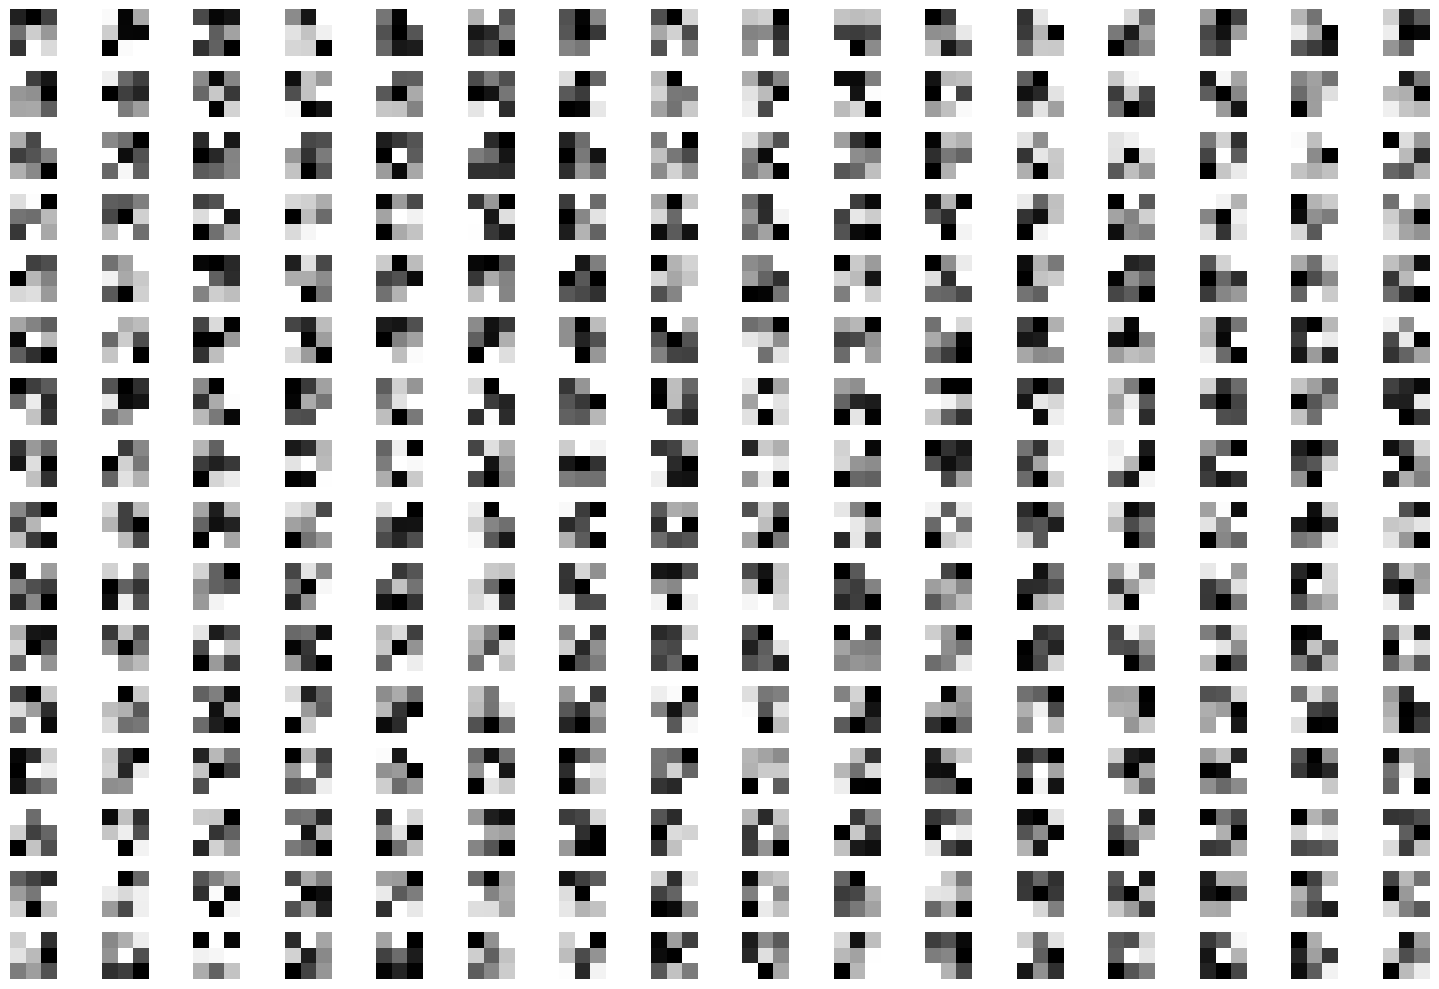

In [48]:
fig = plot_images([x[0,:,:].cpu().detach() for x in param_iter], cmap='gray')       # The '.cpu()' and '.detach()' move the kernels from the GPU to the CPU and thereby allow us to plot them

Execute the above cell for different layer (conv1, conv3, conv6) and compare the kernel visualization. Can you find differences between layers? Can you identify kernel that have a certain structure (lines, circle, etc.)?